In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim



from google.colab import files 
file_uploaded=files.upload()   


Saving covid.zip to covid.zip
2.0.1+cu118


In [2]:
!unzip covid.zip -d covid/ 

Archive:  covid.zip
   creating: covid/test/
   creating: covid/test/covid/
  inflating: covid/test/covid/2covid (1).jpeg  
  inflating: covid/test/covid/2covid (1).jpg  
  inflating: covid/test/covid/2covid (1).png  
  inflating: covid/test/covid/2covid (10).jpeg  
  inflating: covid/test/covid/2covid (10).jpg  
  inflating: covid/test/covid/2covid (10).png  
  inflating: covid/test/covid/2covid (11).jpeg  
  inflating: covid/test/covid/2covid (11).jpg  
  inflating: covid/test/covid/2covid (11).png  
  inflating: covid/test/covid/2covid (12).jpeg  
  inflating: covid/test/covid/2covid (12).jpg  
  inflating: covid/test/covid/2covid (13).jpeg  
  inflating: covid/test/covid/2covid (2).jpeg  
  inflating: covid/test/covid/2covid (2).jpg  
  inflating: covid/test/covid/2covid (2).png  
  inflating: covid/test/covid/2covid (3).jpeg  
  inflating: covid/test/covid/2covid (3).jpg  
  inflating: covid/test/covid/2covid (3).png  
  inflating: covid/test/covid/2covid (4).jpeg  
  inflating: c

In [3]:
data_path = 'covid/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

48


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
test_path = 'covid/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

50


In [7]:
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )        
        self.fc1 = nn.Linear(in_features=193600, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)       
        return out

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001;
model = FashionCNN();
model.to(device)


criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=193600, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=2, bias=True)
)


In [9]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('covid/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [10]:
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

Epoch 0/9
----------


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Loss: 89.5180 Acc: 0.6042

Epoch 1/9
----------
Loss: 134.8462 Acc: 0.4375

Epoch 2/9
----------
Loss: 52.4850 Acc: 0.7292

Epoch 3/9
----------
Loss: 47.9560 Acc: 0.6458

Epoch 4/9
----------
Loss: 23.2715 Acc: 0.7708

Epoch 5/9
----------
Loss: 59.7219 Acc: 0.8125

Epoch 6/9
----------
Loss: 34.6883 Acc: 0.8333

Epoch 7/9
----------
Loss: 16.5490 Acc: 0.7917

Epoch 8/9
----------
Loss: 3.7360 Acc: 0.8958

Epoch 9/9
----------
Loss: 12.3528 Acc: 0.8333

Training complete in 3m 4s
Best Acc: 0.895833


In [11]:

def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    loss_history = [] 
    best_acc = 0.0

    saved_models = glob.glob('covid/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        running_loss = 0.0  

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()

            loss = criterion(outputs, labels) 
            running_loss += loss.item() * inputs.size(0)  

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        epoch_loss = running_loss / len(dataloaders.dataset) 
        print('Acc: {:.4f}, Loss: {:.4f}'.format(epoch_acc, epoch_loss))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)  
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    # 손실 그래프 그리기
    plt.figure()
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('loss_history')
    plt.show()
    
    return acc_history





saved_model ['covid/00.pth', 'covid/01.pth', 'covid/02.pth', 'covid/03.pth', 'covid/04.pth', 'covid/05.pth', 'covid/06.pth', 'covid/07.pth', 'covid/08.pth', 'covid/09.pth']
Loading model covid/00.pth
Acc: 0.2800, Loss: 33.8809

Loading model covid/01.pth
Acc: 0.7200, Loss: 26.2900

Loading model covid/02.pth
Acc: 0.7200, Loss: 14.6885

Loading model covid/03.pth
Acc: 0.7800, Loss: 6.6662

Loading model covid/04.pth
Acc: 0.7200, Loss: 61.8454

Loading model covid/05.pth
Acc: 0.7200, Loss: 65.8286

Loading model covid/06.pth
Acc: 0.7000, Loss: 14.1432

Loading model covid/07.pth
Acc: 0.8400, Loss: 5.1700

Loading model covid/08.pth
Acc: 0.7200, Loss: 21.0104

Loading model covid/09.pth
Acc: 0.7200, Loss: 12.9534

Validation complete in 1m 2s
Best Acc: 0.840000


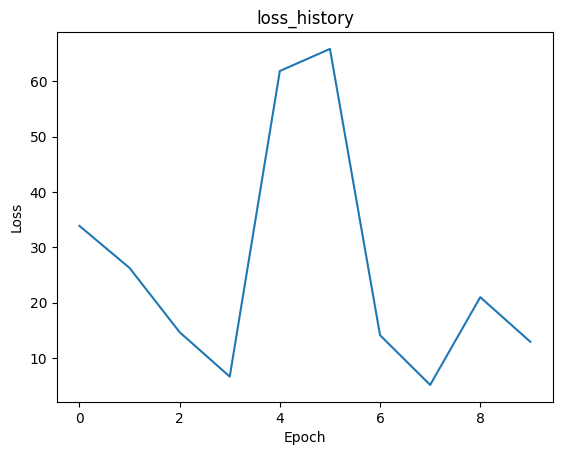

In [12]:
val_acc_hist = eval_model(model, test_loader, device)

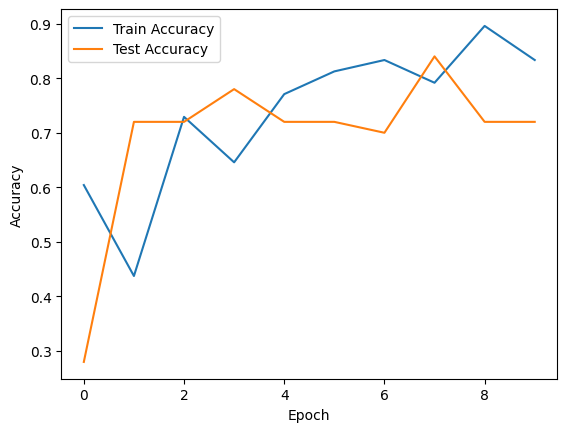

In [13]:
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist,label='Test Accuracy')#test
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()



plt.show()

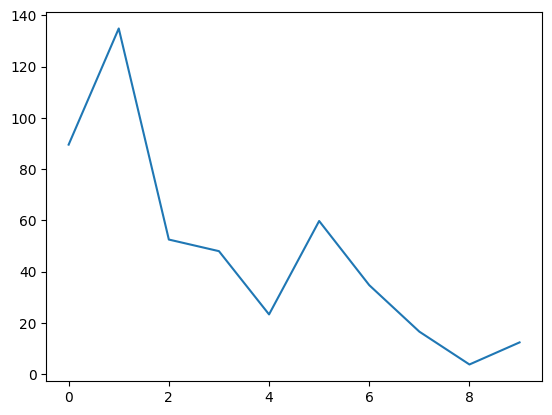

<Figure size 640x480 with 0 Axes>

In [14]:
plt.plot(train_loss_hist,label='train_loss_hist')
plt.figure()
plt.show()

In [21]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

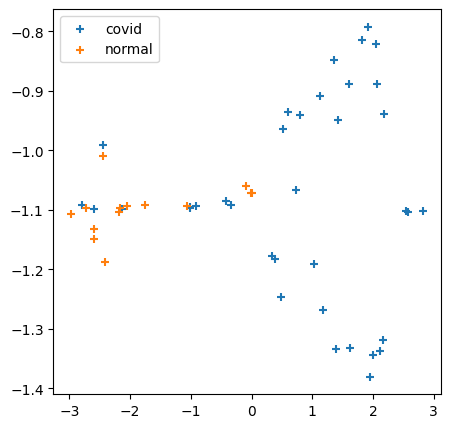

In [22]:
plt.figure(figsize=(5, 5))
name = ['covid','normal']
for i, label in zip(range(2), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='+', label=label)

plt.legend()
plt.show()